In [1]:
import sys

In [2]:
import gbtoolbox.bounds as bounds
import gbtoolbox.misc as mt
import gbtoolbox.dft as dft
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
print(torch.__version__)
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, TensorDataset

/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jonathan/miniconda/envs/torch_fall23/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2.1.0.dev20230830


In [3]:
N = 80
mult = 2*2
span = 2
x = (np.random.rand(mult*N).reshape(-1,2)*2-1)*span/2.0

In [4]:
print(x)

[[-0.14722643 -0.12226085]
 [ 0.51209369 -0.23567592]
 [ 0.39478512 -0.35240375]
 [ 0.76195061 -0.26856211]
 [-0.55147869 -0.84468293]
 [ 0.59820564  0.19236332]
 [-0.96823718 -0.06962176]
 [-0.5080041   0.35458949]
 [-0.51286764 -0.25643459]
 [ 0.96351761 -0.01050864]
 [-0.25705624 -0.21943479]
 [ 0.51853475  0.13186386]
 [ 0.35491702 -0.86261995]
 [ 0.91093992  0.51082055]
 [-0.69381492 -0.04698929]
 [ 0.01376507  0.16153019]
 [ 0.84973752 -0.43197554]
 [-0.42276945  0.24937964]
 [-0.23010508 -0.7125326 ]
 [ 0.64675633  0.06205744]
 [-0.61455197 -0.85675913]
 [-0.27116802 -0.02505186]
 [-0.76250934  0.57437966]
 [-0.6651078  -0.54136539]
 [-0.87850397  0.23576353]
 [-0.92512833  0.45035018]
 [ 0.16807741  0.69069772]
 [ 0.16779198  0.09348015]
 [-0.95629762  0.91820179]
 [ 0.65017244 -0.20735632]
 [ 0.99406566  0.71370541]
 [ 0.66998208  0.32691882]
 [-0.2561267  -0.51772761]
 [ 0.49104152  0.51075963]
 [-0.51434083  0.37496337]
 [ 0.34883961  0.49199429]
 [-0.79179187  0.02477597]
 

Note that in the theory, and in the toolbox, the input space is $[-1,1]^d$. So if your space is $[0,2\pi]^d$ for example, the input needs scaled properly.

In [5]:
y = np.sin(2.1*1*np.pi*x[:,0])*np.sin(3.4*1*np.pi*x[:,1])

We look at a simple function that can be understood analytically to highlight features and use of this toolbox. The function here is $y = \sin(2.1 \pi x_0)\sin(3.4 \pi x_1)$.

In [6]:
f, _ = mt.gen_stacked_equispaced_nd_grid(N,np.array([[-Bt/2.0,Bt/2.0] for Bt in np.array([N/span,N/span])]))
V = span*span
spans = np.tile([-span/2.0,span/2.0],(2,1))
print(f.shape)

(6400, 2)


(6400, 1)


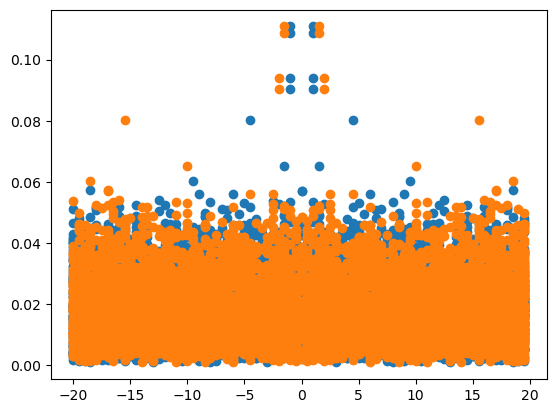

In [7]:
yf = (V/x.shape[0])*dft.nu_dft_cuda(x,y,f,256,128)/(np.sqrt(2*np.pi)**2)
print(yf.shape)
plt.scatter(f[:,0],np.abs(yf))
plt.scatter(f[:,1],np.abs(yf))

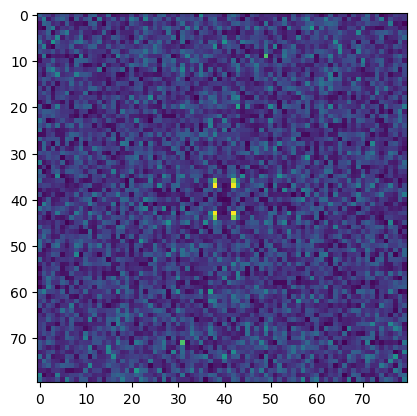

In [8]:
plt.imshow(np.abs(yf).reshape(N,N))

This gives an initial look, we see some noise induced sampling that is down at 0.03. We also see some extended tails going up/down. I would recommend looking at several plots when making cuts, in this one there are no peaks between the ones expected from the analytical calculation.

In [9]:
f, _ = mt.gen_stacked_equispaced_nd_grid(N,np.array([[-Bt/4.0,Bt/4.0] for Bt in np.array([N/span,N/span])]))
V = span*span
spans = np.tile([-span/2.0,span/2.0],(2,1))
print(f.shape)

(6400, 2)


(6400, 1)


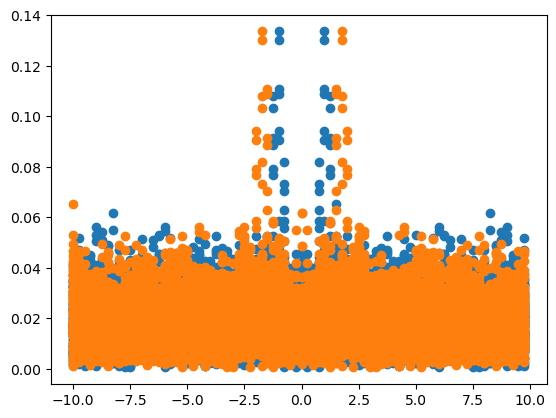

In [10]:
yf = (V/x.shape[0])*dft.nu_dft_cuda(x,y,f,256,128)/(np.sqrt(2*np.pi)**2)
print(yf.shape)
plt.scatter(f[:,0],np.abs(yf))
plt.scatter(f[:,1],np.abs(yf))

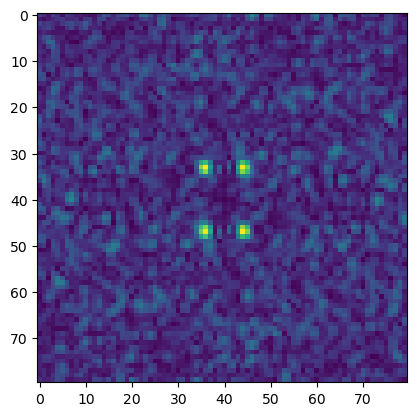

In [11]:
plt.imshow(np.abs(yf).reshape(N,N))


Here instead of an extended line, we see some side lobes, which is suggestive. We also see a lot of gap in the center, but not on one axis. This should have been seen in the previous plot if it was real. So already we are inclined to cut above maybe 0.05 if we use this approximation.

In [12]:
f, _ = mt.gen_stacked_equispaced_nd_grid(N,np.array([[-Bt,Bt] for Bt in np.array([N/span,N/span])]))
V = span*span
spans = np.tile([-span/2.0,span/2.0],(2,1))
print(f.shape)

(6400, 2)


(6400, 1)


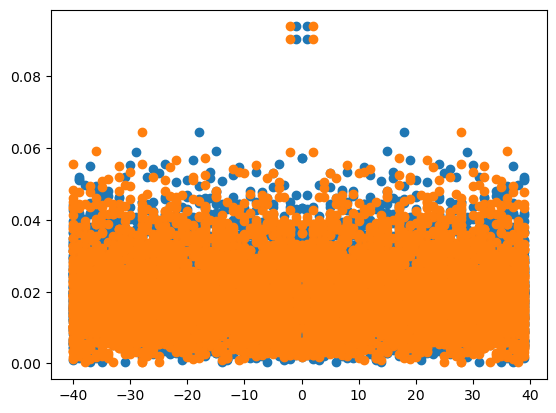

In [13]:
yf = (V/x.shape[0])*dft.nu_dft_cuda(x,y,f,256,128)/(np.sqrt(2*np.pi)**2)
print(yf.shape)
plt.scatter(f[:,0],np.abs(yf))
plt.scatter(f[:,1],np.abs(yf))

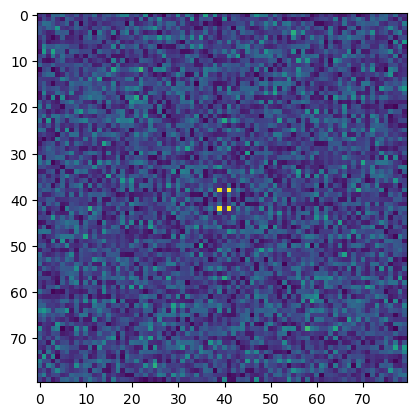

In [14]:
plt.imshow(np.abs(yf).reshape(N,N))

Remember that $w=2\pi f$. Note that we can see two factors here, one with the extension (side lobes in other resolutions) and the other is the random sampling error induced by the low number of samples.

In [15]:
f, _ = mt.gen_stacked_equispaced_nd_grid(N*2,np.array([[-Bt,Bt] for Bt in np.array([4,4])]))
V = span*span
spans = np.tile([-1,1],(2,1))
print(f.shape)

(25600, 2)


(25600, 1)


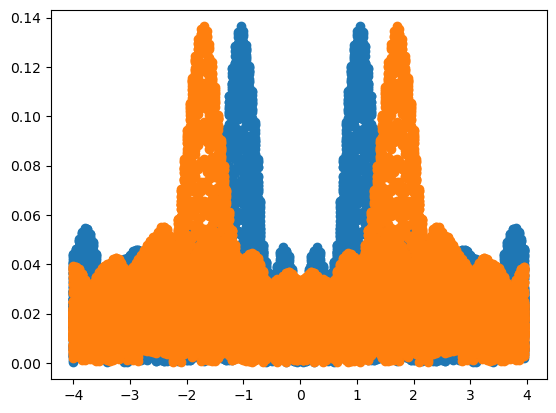

In [16]:
yf = (V/x.shape[0])*dft.nu_dft_cuda(x,y,f,256,128)/(np.sqrt(2*np.pi)**2)
print(yf.shape)
plt.scatter(f[:,0],np.abs(yf))
plt.scatter(f[:,1],np.abs(yf))

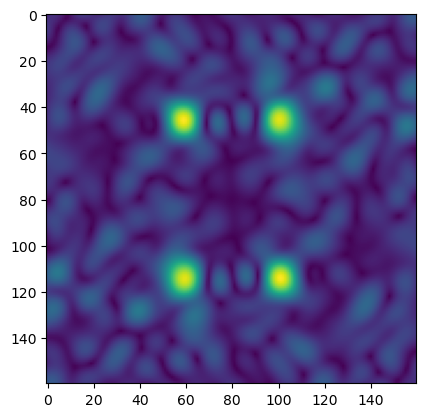

In [17]:
plt.imshow(np.abs(yf).reshape(N*2,N*2))

Text(0, 0.5, 'k')

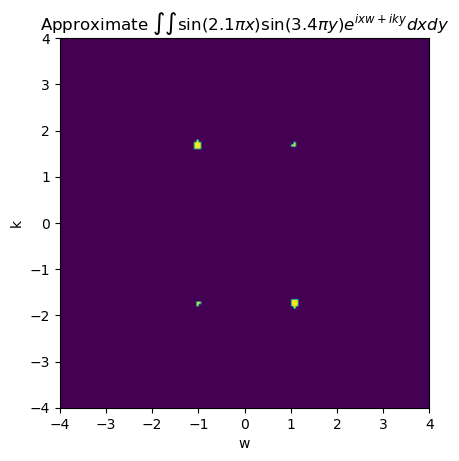

In [27]:
mask = dft.threshold_cmask(yf,0.130)
plt.imshow(np.abs(yf*mask.astype(int)).reshape(N*2,N*2),extent=[-4,4,-4,4])
plt.title('Approximate $\int\int\sin(2.1\pi x)\sin(3.4\pi y)e^{i x w + i k y} dx dy$')
plt.xlabel('w')
plt.ylabel('k')

In these plots we cut for just the 4 peaks. We can clearly cut the other peaks because we see them move as we adjust the resolution in $f$. How tightly to cut the 4 peaks is something that might not be known in general, although we can try periodization to see how wide the real peak is. Here I am making a tight cut, but it could be tighter.

If we increased the statistics, the peaks would become even in size.

In [28]:
sne = bounds.est_spec_norm(f*2*np.pi,yf,None,mask)
print(sne)

635.9009014763345


This is much larger than the analytic calculation, but this is to be expected due the nature of the problem and the nature of the non-equispaced to equispaced FT. Often times we end up with smaller Spectral Norms. This goes into the calculation of the a priori bound.

In [29]:
abnd = bounds.apriori_bound(sne,45000,N*mult/2,2,0.95)
print(abnd)

1366.7918290537461


The bound is high, but then the Barron norm/Spectral norm is high.

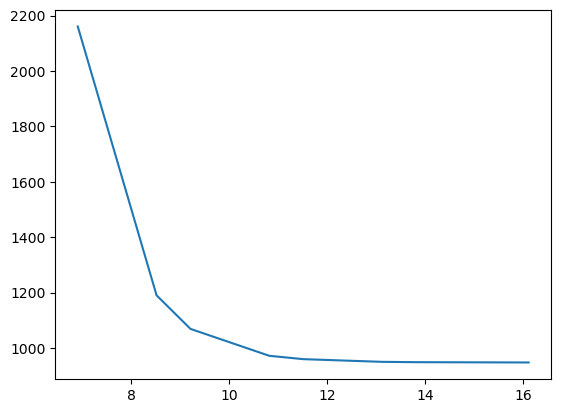

In [30]:
plt.plot(np.log(np.array([1e3,5e3,1e4,5e4,1e5,5e5,1e6,1e7])),[bounds.apriori_bound(sne,MM,N*mult,2,0.95) for MM in np.array([1e3,5e3,1e4,5e4,1e5,5e5,1e6,1e7])])

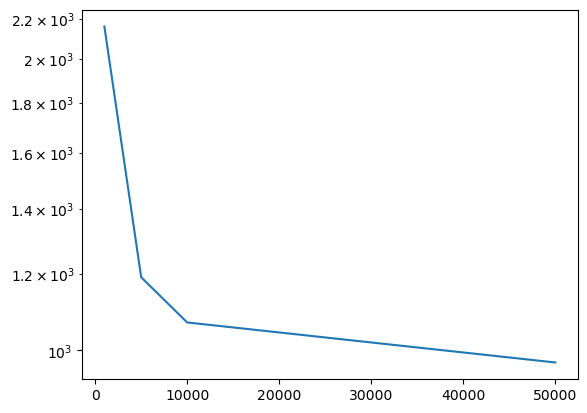

In [31]:
plt.plot(np.array([1e3,5e3,1e4,5e4]),[bounds.apriori_bound(sne,MM,N*mult,2,0.95) for MM in np.array([1e3,5e3,1e4,5e4])])
plt.yscale('log')

We see the expected limiting behavior as a function of number of nodes. Do we see the right behavior if we keep the Spectral norm constant?

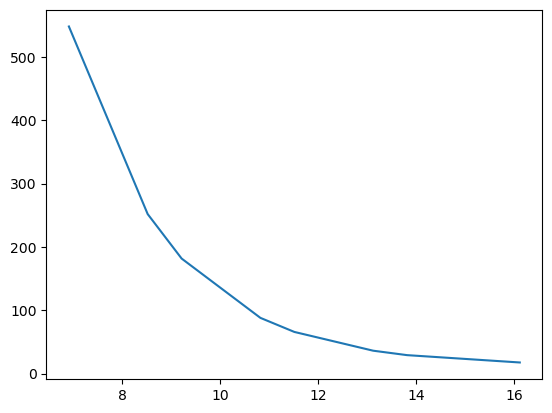

In [32]:
plt.plot(np.log(np.array([1e3,5e3,1e4,5e4,1e5,5e5,1e6,1e7])),[bounds.apriori_bound(sne,1e5,NN,2,0.95) for NN in np.array([1e3,5e3,1e4,5e4,1e5,5e5,1e6,1e7])])

Now, while the Spectral norm/Barron norm is large, we can still use this as part of our initialization. We can then apply the mask to the pdf from the Fourier analytic Barron theory.

Note that to actually get a useful bound, we need to increase statistics (NN), which would also allow us to find a more accurate Barron norm.

In [33]:
pdf=bounds.E_pdf((mask.astype(int)*yf),2*np.pi*((f).T))

In [34]:
MM=45000
zv, tv, wv, sv = pdf.gen_ztw_c(MM)
wh, wn = bounds.nn_wnorm(wv)
print(wh.shape)

(2, 45000)


For the probability density function (pdf), we also use $2\pi f$. Also, if you can initialize well, then the larger the number of nodes the better.

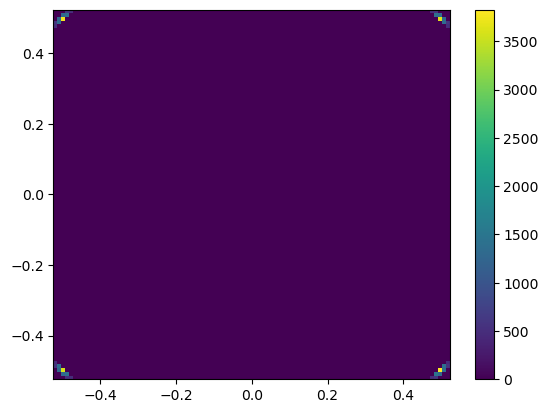

In [35]:
h2d,x2d,y2d,i2d=plt.hist2d(wh.T[:,0],wh.T[:,1],bins=100)
plt.colorbar()

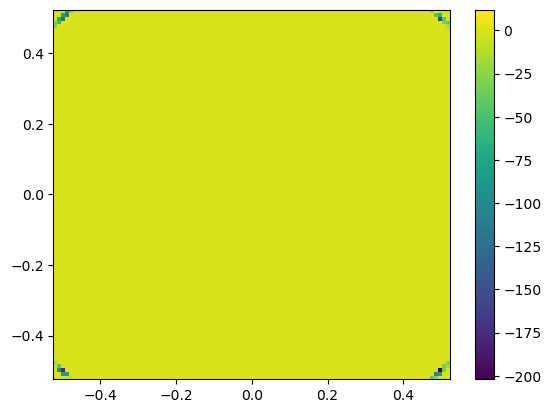

In [36]:
h2d,x2d,y2d,i2d=plt.hist2d(wh.T[:,0],wh.T[:,1],bins=100,weights=sv)
plt.colorbar()

In [37]:
print(np.sum(h2d[:40,:40]))
print(np.sum(h2d[:40,60:]))
print(np.sum(h2d[60:,:40]))
print(np.sum(h2d[60:,60:]))

-518.0
-637.0
-573.0
-408.0


Here we know the answer, so we know that each 'peak' should be equal in magnitude but two negative and two positive. We see a smallish assymetry here, and it is this assymetry, from the outer weight sign, that drives the linear gradient that can be very strong in the approximation. The sign will be more accurate the more accurate the approximate FT is. 

(array([23568.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21432.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

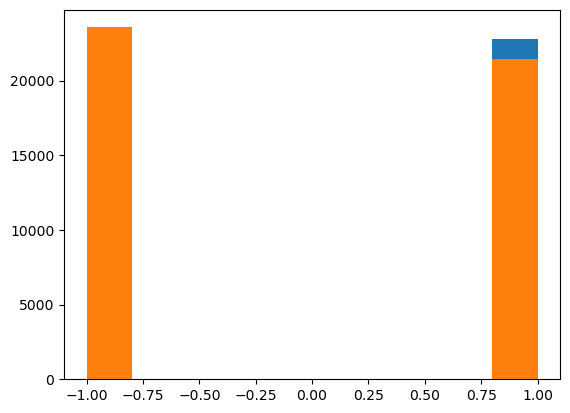

In [38]:
plt.hist(zv)
plt.hist(sv)

One possible solution is to provide both -1 and 1 to the network, with some small 'noise' difference in magnitude, and then let training the neural network move the wrong sign to 0. We don't expect the argument of the approximate Fourier transform to be as well determined as the magnitude.

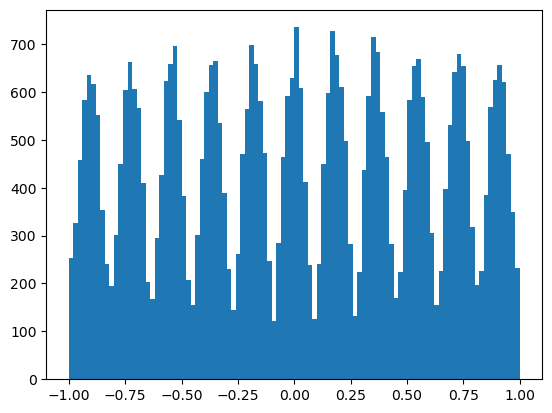

In [39]:
plt.hist(tv*zv,bins=100)
plt.show()

This  behaves well here. Since we have only a single value for $\|w\|_1$, analytically, we would expect behavior that is approximately $|\cos(\|w\|_1 t)|$.

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
tensor_x = torch.Tensor(x) # transform to torch tensor
tensor_y = torch.Tensor(y)

In [42]:
print(torch.backends.cudnn.is_available())

True


In [43]:

class ShallowRegressor(nn.Module):
    def __init__(self):
        super(ShallowRegressor,self).__init__()
        self.fc1 = nn.Linear(2,MM)
        self.fc2 = nn.Linear(MM,1)     
        self.fc1.weight = torch.nn.Parameter(torch.Tensor(wh.T))
        self.fc1.bias = torch.nn.Parameter(torch.Tensor(tv*zv))      
        self.fc2.bias = torch.nn.Parameter(torch.Tensor(np.array([np.mean(y)])))
        self.fc2.weight = torch.nn.Parameter(torch.Tensor((sne)*(sv).reshape(-1,1).T/MM))
      
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

We can improve in practice, note that since our value for the Barron norm is significantly off, that the overall scale (from the outer weights) is going to be off. We provide a correction for that below.

In [44]:
model = ShallowRegressor()

In [45]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

In [46]:
loss_fn = torch.nn.MSELoss()

In [47]:
model = model.to(device)

In [48]:
print(tensor_x.shape)
ABS = 60
XX = np.linspace(-1,1,ABS,endpoint=False)
XXg = mt.grid_to_stack(np.meshgrid(XX,XX))
print(XXg.shape)

torch.Size([160, 2])
(3600, 2)


In [49]:
model.eval()
YYg = model(torch.Tensor(XXg).to(device))

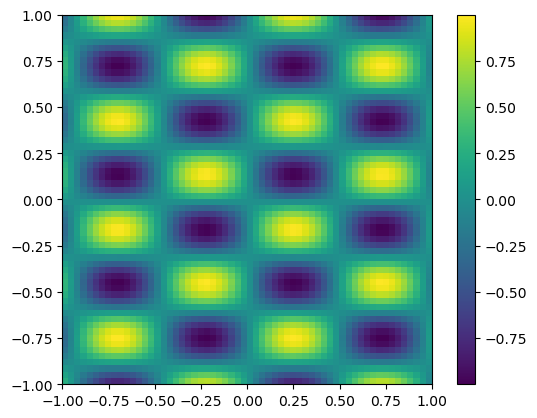

In [50]:
plt.imshow((np.sin(2.1*1*np.pi*XXg[:,0])*np.sin(3.4*1*np.pi*XXg[:,1])).reshape(ABS,ABS),extent=[-1, 1, -1, 1])
plt.colorbar()

We see a nice simple pattern.

torch.Size([3600, 1])


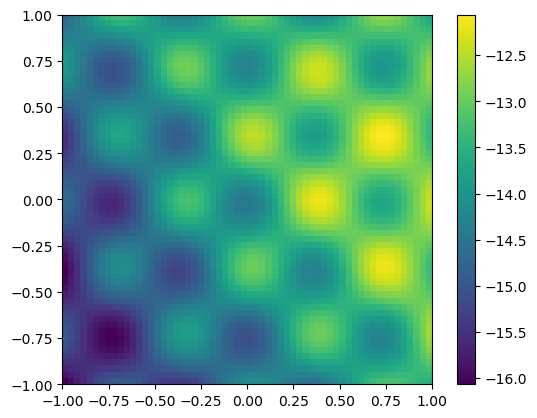

In [51]:
print(YYg.shape)
plt.imshow(YYg.detach().cpu().numpy().reshape(ABS,ABS),extent=[-1,1, -1, 1])
plt.colorbar()

We see the same patern, but probably with a different scale (maybe even more than 10x too high) and with some roughly linear gradient. This is because of our lower approximate Fourier transform. If the 4 peaks are a bit unbalanced due to the number of samples, we will get a gradient. If we have a too large Spectral norm, we will be too high. If we don't cut agressively enough and include a lot more of the region around the peak, we will have a gradient. This all requires some work. 

In general we want to do as good of job as we can, and then possibly do additional corrections with training.

In [52]:
print(x.shape)

(160, 2)


torch.Size([3600, 1])
4.004775
1.998574704120086
-5.020365503779825


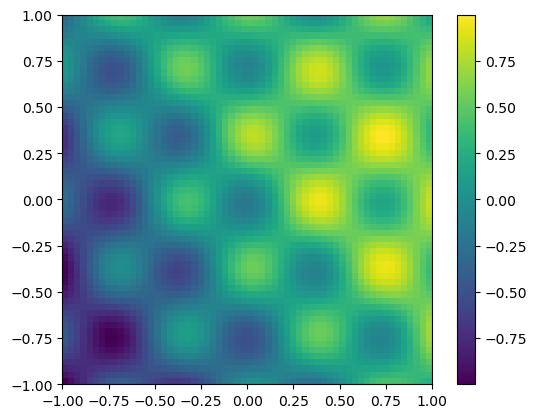

In [53]:
print(YYg.shape)
maxYY=np.max(YYg.detach().cpu().numpy())
maxXX=np.max((np.sin(2.1*1*np.pi*XXg[:,0])*np.sin(3.4*1*np.pi*XXg[:,1])))
factorYY=np.max(YYg.detach().cpu().numpy())-np.min(YYg.detach().cpu().numpy())
factorXX=np.max((np.sin(2.1*1*np.pi*XXg[:,0])*np.sin(3.4*1*np.pi*XXg[:,1])))-np.min((np.sin(2.1*1*np.pi*XXg[:,0])*np.sin(3.4*1*np.pi*XXg[:,1])))
print(factorYY)
print(factorXX)
print(maxYY/factorYY*factorXX+maxXX)
plt.imshow(YYg.detach().cpu().numpy().reshape(ABS,ABS)/factorYY*factorXX-maxYY/factorYY*factorXX+maxXX,extent=[-1,1, -1, 1])
plt.colorbar()

Here we use the truth to scale, but in general practice it may be a good idea to use the predictions of the training set from the initial initialization to rescale the outer weights. So the weights are initialized with a second process.

In [59]:
xt = (np.random.rand(mult*N*100).reshape(-1,2)*2-1)*span/2.0
yt = np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])

Text(0, 0.5, 'y')

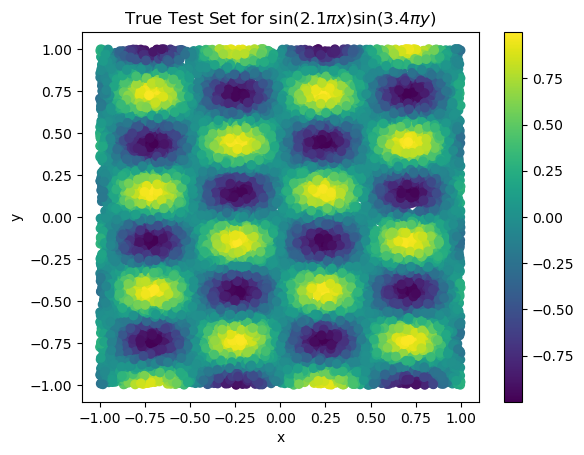

In [60]:
plt.scatter(xt[:,0], xt[:,1], c=(np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])))
plt.colorbar()
plt.title('True Test Set for $\sin(2.1\pi x)\sin(3.4\pi y)$')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

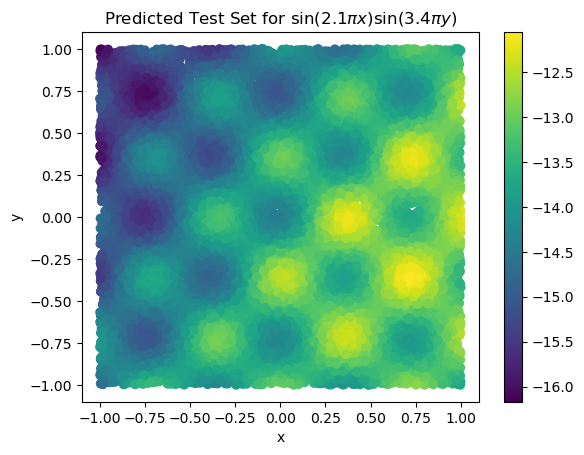

In [61]:
plt.scatter(xt[:,0], xt[:,1], c=model(torch.Tensor(xt).to(device)).detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Test Set for $\sin(2.1\pi x)\sin(3.4\pi y)$')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

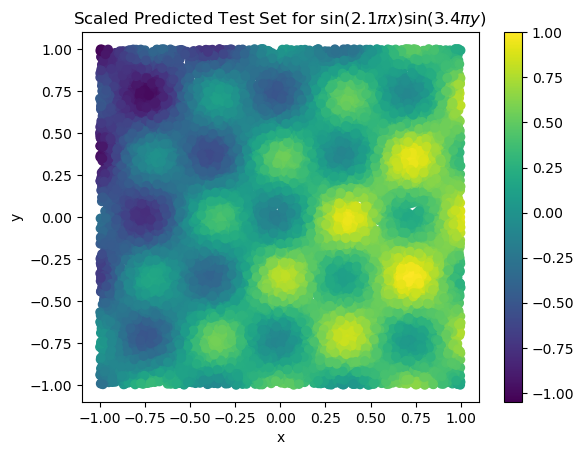

In [62]:
scaled = model(torch.Tensor(xt).to(device)).detach().cpu().numpy()/factorYY*factorXX-maxYY/factorYY*factorXX+maxXX
plt.scatter(xt[:,0], xt[:,1], c=scaled)
plt.colorbar()
plt.title('Scaled Predicted Test Set for $\sin(2.1\pi x)\sin(3.4\pi y)$')
plt.xlabel('x')
plt.ylabel('y')

In [63]:
np.square(np.subtract((np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])).reshape(-1,1), model(torch.Tensor(xt).to(device)).detach().cpu().numpy()/factorYY*factorXX-maxYY/factorYY*factorXX+maxXX)).mean()

0.42255542716334266

While we do get many of the correct overall features, even from the few data points, we do get an overall gradient which could be corrected for with additional training. The shape is a little different, but this will improve as the approximate Fourier transform is improved (either by a better threshold or by having more sample data).

For a shallow neural network, we found a close prediction fo the truth based off of a fairly small data sample.

The MSE is good but not incredible, but improves as the number of samples provided to the approximate Fourier transform increases.

Text(0, 0.5, 'y')

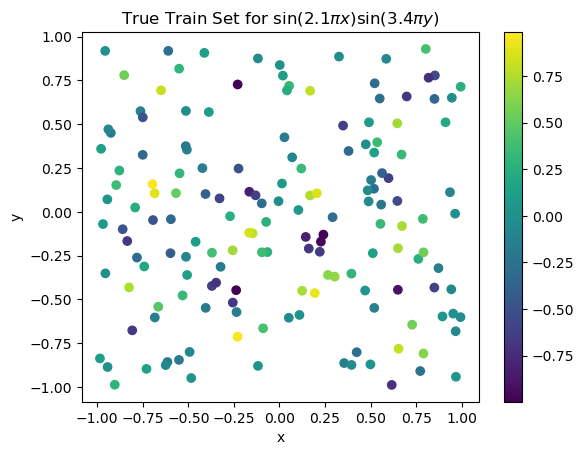

In [64]:
plt.scatter(x[:,0], x[:,1], c=y)
plt.colorbar()
plt.title('True Train Set for $\sin(2.1\pi x)\sin(3.4\pi y)$')
plt.xlabel('x')
plt.ylabel('y')

In [65]:
class ShallowRegressor2(nn.Module):
    def __init__(self):
        super(ShallowRegressor2,self).__init__()
        self.fc1 = nn.Linear(2,MM)
        self.fc2 = nn.Linear(MM,1)     
        #self.fc1.weight = torch.nn.Parameter(torch.Tensor(wh.T))
        #self.fc1.bias = torch.nn.Parameter(torch.Tensor(tv*zv))      
        #self.fc2.bias = torch.nn.Parameter(torch.Tensor(np.array([np.mean(y)])))
        #self.fc2.weight = torch.nn.Parameter(torch.Tensor((sne)*(sv).reshape(-1,1).T/MM))
      
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [66]:
model2 = ShallowRegressor2()
model2 = model2.to(device)
model2.eval()

ShallowRegressor2(
  (fc1): Linear(in_features=2, out_features=45000, bias=True)
  (fc2): Linear(in_features=45000, out_features=1, bias=True)
)

Text(0, 0.5, 'y')

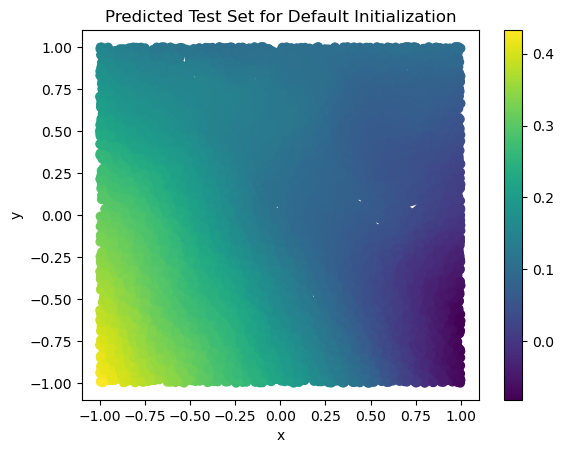

In [67]:
plt.scatter(xt[:,0], xt[:,1], c=model2(torch.Tensor(xt).to(device)).detach().cpu().numpy())
plt.colorbar()
plt.title('Predicted Test Set for Default Initialization')
plt.xlabel('x')
plt.ylabel('y')

If we look at the standard initialization we find that we get something that doesn't look anything like the target function. Additionally, the Mean Square Error is signficantly higher.

In [68]:
np.square(np.subtract((np.sin(2.1*1*np.pi*xt[:,0])*np.sin(3.4*1*np.pi*xt[:,1])).reshape(-1,1), model2(torch.Tensor(xt).to(device)).detach().cpu().numpy()/factorYY*factorXX-maxYY/factorYY*factorXX+maxXX)).mean()

50.579971570761174

A good initialization allows a neural network to produce a good approximation both faster and a better quality approximation. 